# **Использование различных оптимизаторов для минимизации весов нейронных сетей на основе набора данных MNIST**

MNIST - является классических набором данных для задачи распознавания рукописных цифр.

Ваш ИСУ id и ФИО:

489408 Киселёв Михаил Васильевич

**Задание:**
1. Обучить и измерить точность нейросетей с различными предложенными оптимизаторами из библиотеки PyTorch
2. Построить графики длительности обучения, точности результатов, загрузки CPU и использования оперативной памяти.
3. Сделать анализ полученных результатов. (разде 9)
4. Добавить собственные оптимизаторы из коллекции библиотеки Pytorch.
5. Повторить шаги 2-3.
6. *Можно попробовать оптимизаторы из других библиотек, но не все они могут быть совместимы с Pytorch архитектурой (см. раздел 10).

Так как нейронные сети могут обучаться достаточно долго, то запускать их можно по одной, чтобы не потерять результаты.

По указаной же выше причине, можно сначала поставить нейронные сети тренироваться, а в это время заняться изучением теоретической шпаргалки в разделе 1.

В разделе 9, секцию А можно заполнять, пока нейронные сети ещё учатся.

In [1]:
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### **Советы для студентов**
1. Для методов второго порядка (например, Ньютона) уменьшайте размерность данных (например, используйте `28x28 → 14x14`), чтобы гессиан не занимал слишком много памяти.
2. Экспериментируйте с `batch_size` для баланса между памятью и скоростью.
3. Используйте `torch.jit` для оптимизации вычислений.

#### **1. Теоретическая шпаргалка**
### **1. Основы методов оптимизации**
#### **1.1 Градиентный спуск и его модификации**
- **Формула обновления параметров**:  
  $ \theta_{t+1} = \theta_t - \eta \nabla L(\theta_t) $,  
  где $ \eta $ — learning rate, $ \nabla L $ — градиент функции потерь.
- **Стохастический градиентный спуск (SGD)**:  
  Использование подвыборки (батча) для оценки градиента.  
  Плюсы: низкая вычислительная стоимость.  
  Минусы: шум, медленная сходимость.
- **Метод моментов**:  
  $ v_{t+1} = \beta v_t + (1-\beta) \nabla L(\theta_t) $,  
  $ \theta_{t+1} = \theta_t - \eta v_{t+1} $.  
  Идея: инерция для подавления шума.

#### **1.2 Методы второго порядка**
- **Метод Ньютона**:  
  $ \theta_{t+1} = \theta_t - H^{-1}(\theta_t) \nabla L(\theta_t) $,  
  где $ H $ — гессиан.  
  Проблемы: вычисление $ H^{-1} $ для больших моделей ($ O(n^3) $).
- **Квазиньютоновские методы (L-BFGS)**:  
  Аппроксимация гессиана с помощью истории градиентов.  
  Преимущества: меньше памяти, чем у полного BFGS.

#### **1.3 Адаптивные методы**
- **RMSProp**:  
  Адаптивный шаг на основе скользящего среднего квадратов градиентов:  
  $ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma) g_t^2 $,  
  $ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t $.  
- **Adam**:  
  Комбинация моментов первого и второго порядка:  
  $ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $,  
  $ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $,  
  $ \theta_{t+1} = \theta_t - \frac{\eta \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $.  
  Здесь $ \hat{m}_t $ и $ \hat{v}_t $ — bias-corrected оценки.

---

### **2. Связь с системами нелинейных уравнений**
#### **2.1 Постановка задачи**
- Система уравнений: $ F(\theta) = 0 $, где $ F: \mathbb{R}^n \to \mathbb{R}^n $.  
- Для оптимизации: $ F(\theta) = \nabla L(\theta) = 0 $.

#### **2.2 Метод Ньютона для систем**
- Итерация: $ \theta_{t+1} = \theta_t - J^{-1}(\theta_t) F(\theta_t) $,  
  где $ J $ — якобиан $ F $.  
- Для оптимизации $ J = H $ (гессиан функции потерь).

#### **2.3 Квазиньютоновские методы**
- Аппроксимация $ J^{-1} $ без явного вычисления матрицы (L-BFGS).  
- Условие секущих: $ J_{t+1} (\theta_{t+1} - \theta_t) = F(\theta_{t+1}) - F(\theta_t) $.

---

### **3. Практические аспекты в глубоком обучении**
#### **3.1 Почему метод Ньютона не используется напрямую?**
- Вычислительная сложность: $ O(n^3) $ для обращения матрицы.  
- Память: хранение гессиана для $ n=10^6 $ параметров требует $ 10^{12} $ элементов.  
- Решение: квазиньютоновские методы и адаптивные оптимизаторы.

#### **3.2 Сравнение методов**
| **Метод**      | **Порядок** | **Память** | **Сходимость**       | **Гиперпараметры**   |
|----------------|-------------|------------|----------------------|----------------------|
| SGD            | 1-й         | $ O(n) $ | Медленная            | Learning rate        |
| Adam           | 1-й         | $ O(n) $ | Быстрая             | $ \beta_1, \beta_2 $ |
| L-BFGS         | 2-й         | $ O(mn) $ | Суперлинейная       | Размер истории ($ m $) |

#### **3.3 Адаптивные методы vs. методы второго порядка**
- **Adam/RMSProp**: Хороши для noisy gradients, не требуют точного вычисления кривизны.  
- **L-BFGS**: Эффективен на гладких задачах, но чувствителен к шуму и требует точного линейного поиска.

---

### **4. Ключевые концепции для анализа**
#### **4.1 Скорость сходимости**
- Линейная (SGD), суперлинейная (L-BFGS), адаптивная (Adam).  
- Теоретическая основа: условия Липшица для градиента и гессиана.

#### **4.2 Память и вычислительная стоимость**
- **Методы 1-го порядка**: $ O(n) $ — хранение градиентов.  
- **Методы 2-го порядка**: $ O(mn) $ — хранение истории градиентов (L-BFGS).  
- **Время на итерацию**: SGD — $ O(batch \cdot n) $, L-BFGS — $ O(m \cdot batch \cdot n) $.

#### **4.3 Проблемы обучения**
- **Застревание в локальных минимумах**: Как методы с моментом (Adam) помогают их избежать.  
- **Сглаживание шума**: Роль экспоненциального скользящего среднего в Adam.

---

### **5. Визуализации для понимания**
1. **График ландшафта функции потерь**:  
   - Как методы 1-го и 2-го порядка двигаются к минимуму.

2. **Графики сходимости**:  
   - Сравнение loss vs. итерации для SGD, Adam, L-BFGS.  
   - Пример из [статьи](https://debuggercafe.com/wp-content/uploads/2020/06/adam_result_mnist.png):  
     ![Optimizers Comparison](https://debuggercafe.com/wp-content/uploads/2020/06/adam_result_mnist.png) .

---

### **6. Рекомендуемые дополнительные источники**
1. **Книги**:  
   - Boyd & Vandenberghe, "Convex Optimization" (Глава 9 — Методы Ньютона).  
   - Goodfellow et al., "Deep Learning" (Глава 8 — Оптимизация).  
2. **Статьи**:  
   - [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980).  
   - [On the Limited Memory BFGS Method for Large Scale Optimization](https://link.springer.com/article/10.1007/BF01589116).  
3. **Лекции**:  
   - [CS231n: Optimization](https://cs231n.github.io/optimization-1/).  

# **Конец теоретической шпаргалки**
---

---

#### **2. Установка зависимостей**

In [2]:
!pip install memory_profiler psutil

---

#### **3. Предобработка данных MNIST**

In [3]:
import torch
from torchvision import datasets, transforms

device = torch.device("cpu")

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Конвертирует PIL.Image в тензор
    transforms.Normalize((0.5,), (0.5,))
])
# Загрузка данных
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform  # Применяем преобразования
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)



# Преобразование в DataLoader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.24MB/s]


---

#### **4. Определение модели (полносвязная сеть)**

In [4]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.layers(x)


In [16]:
@monitor_resources
def train_model(optimizer_class, model, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            def closure():
                optimizer_class.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer_class.step(closure)
    return model


---

#### **5. Инструменты для мониторинга ресурсов**

In [5]:
import time
import psutil
from memory_profiler import memory_usage

def monitor_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_mem = memory_usage(-1, interval=0.1)[0]
        process = psutil.Process()
        cpu_percent_start = process.cpu_percent(interval=None)

        result = func(*args, **kwargs)

        end_time = time.time()
        end_mem = memory_usage(-1, interval=0.1)[0]
        cpu_percent_end = process.cpu_percent(interval=None)

        metrics = {
            "time": end_time - start_time,
            "memory": end_mem - start_mem,
            "cpu": cpu_percent_end - cpu_percent_start
        }
        return result, metrics
    return wrapper


---

#### **6. Обучение модели с разными оптимизаторами**

In [15]:
def evaluate_model(model, test_loader):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

---

#### **7. Сравнение методов**

In [18]:
results = {}

In [10]:
# По своему усмотрению Вы можете добавлять собственные оптимизаторы
methods = {
    "Adam": torch.optim.Adam,
    "L-BFGS": torch.optim.LBFGS,
    "SGD": torch.optim.SGD,
    "RMSProp": torch.optim.RMSprop
}

In [8]:
def get_nn_score(opt):
        model = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opt(model.parameters())
        trained_model, metrics = train_model(optimizer, model, criterion)
        accuracy = evaluate_model(trained_model, test_loader)
        return {"accuracy": accuracy, **metrics}

In [19]:
# Тренируем и оцениваем все варианты нейронных сетей с разными оптимизаторами (может быть долго, больше часа):
# for name, opt in methods.items():
    # results[name] = get_nn_score(opt)

# Или запускаем модели по одной (безопаснее, если захотим перезапустить или что-то сломается в процессе, чтобы не потерять прогресс)
results["Adam"] = get_nn_score(methods["Adam"])

In [ ]:
results["L-BFGS"] = get_nn_score(methods["L-BFGS"])

In [21]:
results["SGD"] = get_nn_score(methods["SGD"])

In [22]:
results["RMSProp"] = get_nn_score(methods["RMSProp"])

Пока обучаются нейронные сети, можете переходить в раздел 9 к секции А, она не требует результатов запуска нейронных сетей.

---

#### **8. Визуализация результатов**
- **График точности**:

Text(0.5, 1.0, 'Accuracy Comparison')

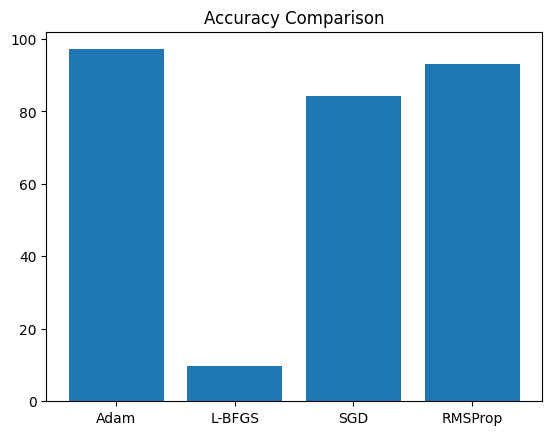

In [ ]:
  import matplotlib.pyplot as plt

  plt.bar(results.keys(), [v["accuracy"] for v in results.values()])
  plt.title("Accuracy Comparison")

- **Графики времени обучения**:

Text(0.5, 1.0, 'Training time Comparison')

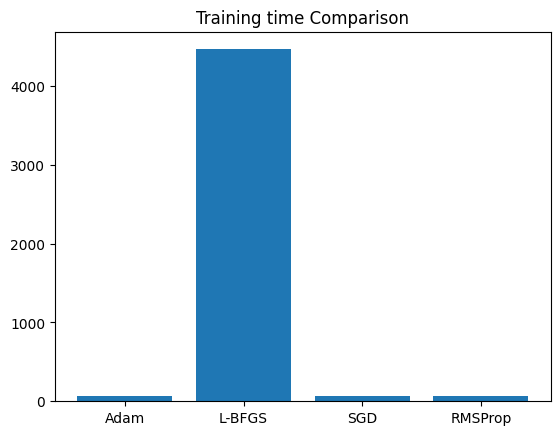

In [ ]:
  plt.bar(results.keys(), [v["time"] for v in results.values()])
  plt.title("Training time Comparison")

- **Графики пямяти**:

Text(0.5, 1.0, 'Training RAM usage Comparison')

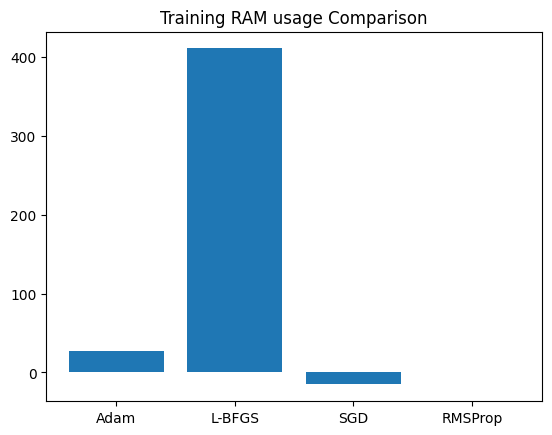

In [ ]:
  plt.bar(results.keys(), [v["memory"] for v in results.values()])
  plt.title("Training RAM usage Comparison")

- **График потребления CPU**

Text(0.5, 1.0, 'Training CPU usage Comparison')

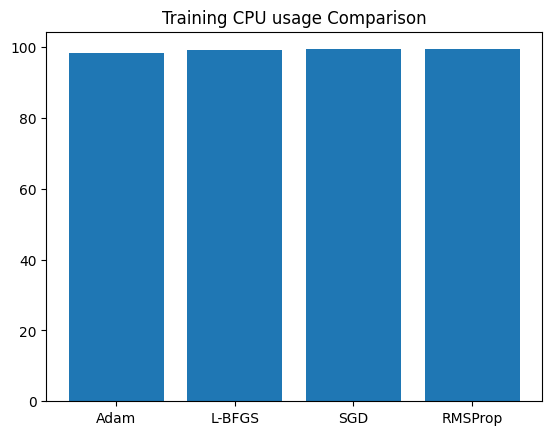

In [ ]:
  plt.bar(results.keys(), [v["cpu"] for v in results.values()])
  plt.title("Training CPU usage Comparison")

---

#### **9. Анализ полученных результатов:**

### **А. Математические основы методов**
1. **Связь с изученными методами**  
   - Какой из оптимизаторов (напр., L-BFGS, Adam) ближе всего к методу Ньютона? В чём их сходство и различия?  
   - Почему в Adam используется адаптивный шаг, и как это связано с идеями метода градиентного спуска?  
   - Для методов второго порядка (например, L-BFGS):  
     - Как вычисляется приближение гессиана, и почему это важно для сходимости?  
     - Почему полный метод Ньютона редко применяется в глубоком обучении?  

Оптимизатор Adam более близок к методу Ньютона, так как их функции обновления параметрроа наиболее схожи по своему виду вычисления.

Adam использует адаптивный шаг, чтобы контролировать сходимость алгоритма, соблюдая баланс между точностью и выходом из локальных минимумов.

Метод Ньютона редко используется на практике в глубоком обучении, так как он слишком затратен с точки зрения вычислений обратной матрицу гессен.


2. **Алгоритмические особенности**  
   - Чем отличается стохастический градиентный спуск (SGD) от полного градиентного спуска? Как это влияет на сходимость?  
   - Как метод L-BFGS балансирует между использованием информации о кривизне функции и вычислительной сложностью?  

Используются не все данные, а только некоторая подвыборка из общих данных.
Это уменьшает стоимость вычислений, но при это теряется точность, за счёт уменьшения количества обрабатываемых данных.

### **Б. Анализ скорости сходимости**
3. **Графики потерь и точности**  
   - Почему Adam часто сходится быстрее, чем SGD, несмотря на стохастичность?  
   - Если L-BFGS показал медленную сходимость на первых итерациях, но затем резко улучшил результат, чем это может быть объяснено?

Так как Adam использует метод моментов и адаптивный шаг в вычисления, а SGD делает класичесский градиетный спуск только на подвыборки данных.
4. **Роль гиперпараметров**  
   - Как выбор learning rate влияет на методы:  
     - С адаптивным шагом (Adam, RMSProp)?  
     - Без адаптивного шага (SGD, L-BFGS)?  
   - Почему для L-BFGS часто требуется меньше эпох, но больше времени на одну эпоху?


Для SGD, L-BFGS(они линейны) важен выбор оптимальной скорости обучения, так как иначе алгоритмы сойдутся либо слишком рано, либо слишком долго, а алгоритмы с адаптивным шагом смогут изменить шаг на более оптимальный.

### **5. Связь с теорией нелинейных систем**
9. **Интерпретация методов**  
   - Как метод Ньютона для систем нелинейных уравнений связан с оптимизацией в глубоком обучении?  
   - Почему в SGD используется приближённый градиент, и как это влияет на устойчивость метода?
   
Так как нам требуется уменьшить вычислительную стоимость, за счёт обобщённости градиента, что позволяет нам быстрее его вычислить, но теряется точность вычислений.

10. **Проблемы реализации**  
    - Какие численные проблемы возникают при вычислении гессиана в методах второго порядка (например, L-BFGS)?  
    - Как методы вроде Adam избегают проблем "застревания" в локальных минимумах?  

Потеря точности, высокая вычислительная стоимость.

Adam это решает за счёт адаптивного шага, который позволяет избегать ранней сходимости в локальном минимуме.

#### **10. Что ещё можно попробовать для этого набора данных?**
- Метод [forward gradient descent](https://github.com/orobix/fwdgrad).
- Оптимизаторы из других библиотек, например, [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), [TensorFlow / Keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).